In [1]:
import numpy as np
import pandas as pd

import math

import scipy.stats as st
import scipy.signal as si
from scipy.integrate import simps

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import ChebConv, TopKPooling, GCNConv
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import f1_score

import scipy.stats as sps

import mne
from mne import io
from mne.datasets import sample

import os
module_path = os.path.abspath(os.path.join('./src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from graph_rewiring import apply_KNN, apply_beltrami
from base_classes import BaseGNN
from model_configurations import set_block, set_function


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
plt.rcParams.update({'font.size': 18})

In [3]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-

In [4]:
processed_filename = 'dataset/smni_eeg.npz'
df = np.load(processed_filename)
data, labels = df['data'], df['labels']

Nsubjects, Nchannels, Ntime, Nconditions = data.shape

# # For simplicity we will only use 1 condition out of 3 and take every second electrode
data = data[:, ::2, :, 0]

# sample_frequency = 256 # Hz
# timepoints = 1000.0 * np.arange(Ntime) / sample_frequency # ms

# ind_alcohol = list(np.where(labels == 0)[0])[:10] #[:10] is to make tensor smaller
# ind_control = list(np.where(labels == 1)[0])[:10] #[:10] is to make tensor smaller

# fig, ax = plt.subplots(2, 1, figsize=(15, 4))

# ax[0].plot(timepoints, data[ind_alcohol[2], 4, :].T, color='k');
# ax[1].plot(timepoints, data[ind_control[2], 4, :].T, color='k');

# ax[1].set_xlabel('time, ms');
# ax[0].set_ylabel('voltage, mV');
# ax[1].set_ylabel('voltage, mV');
# ax[0].set_title('EEG signals on one of the electrodes (addicted to alcohol)');
# ax[1].set_title('EEG signals on one of the electrodes (control)');
# ax[0].set_ylim([-10, 10])
# ax[1].set_ylim([-10, 10])
# plt.tight_layout()

In [4]:
data_path = str(sample.data_path())
raw_fname = data_path + "/MEG/sample/sample_audvis_filt-0-40_raw.fif"
event_fname = data_path + "/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif"
tmin, tmax = -0.0, 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method="iir")  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info["bads"] = ["MEG 2443"]  # set bad channels
picks = mne.pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads"
)

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=False,
    picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)

labels = epochs.events[:, -1]
evoked = epochs.average()
data = epochs.get_data(copy=False)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



In [5]:
n_objects, n_channels, n_time_measurements = data.shape
data.shape

(119, 32, 256)

In [6]:
labels.shape

(119,)

In [7]:
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.25, random_state = 123)
train_ids, test_ids = next(splitter.split(data, labels))

X_train, X_test = data[train_ids], data[test_ids]
y_train, y_test = labels[train_ids], labels[test_ids]

In [8]:
def euclidean_dist_adjacency(el_pos_3d: np.array) -> np.array:
    n_ch = len(el_pos_3d)
    dist_matrix = np.zeros((n_ch, n_ch))

    for i in range(n_ch):
        for j in range(i):
            dist_matrix[i][j] = 1 / np.linalg.norm(el_pos_3d[i] - el_pos_3d[j])

    dist_matrix += dist_matrix.T
    dist_matrix /= dist_matrix.max()
    return dist_matrix


def geodesic_dist_adjacency(el_pos_3d: np.array) -> np.array:
    el_pos_3d /= np.linalg.norm(el_pos_3d.astype(float), axis=1, keepdims=True)
    n_ch = len(el_pos_3d)
    dist_matrix = np.zeros((n_ch, n_ch))

    r = 1
    for i in range(n_ch):
        for j in range(i):
            dist_matrix[i][j] = 1 / (r * math.acos(round(np.dot(el_pos_3d[i], el_pos_3d[j]) / (r ** 2), 2)))

    dist_matrix += dist_matrix.T
    dist_matrix /= dist_matrix.max()
    return dist_matrix


def pearson_corr_adjacency(x):
    # n_ch = x.shape[0]
    # corr_matrix = np.zeros((n_ch, n_ch))
    # for i in range(n_ch):
    #     for j in range(i):
    #         corr_matrix[i][j] = st.pearsonr(x[i, :], x[j, :])[0]
    # corr_matrix += corr_matrix.T
    # corr_matrix = np.abs(corr_matrix)
    num = ((x[:, None, :] - x.mean(axis=-1)[:, None, None,]) * (x[None, :, :] - x.mean(axis=-1)[None, :, None])).mean(axis=-1)
    denom = np.sqrt(x.var(axis=-1)[None, :] * x.var(axis=-1)[:, None]).squeeze()
    corr_matrix = num / denom
    corr_matrix[np.arange(corr_matrix.shape[0]), np.arange(corr_matrix.shape[0])] = 0
    corr_matrix = np.abs(corr_matrix)

    return corr_matrix


def calculate_coherence(x, y, sf, low_freq, hi_freq):
    nperseg = (2 / low_freq) * sf
    freqs, coh = si.coherence(x, y, fs=sf, nperseg=nperseg)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low_freq, freqs <= hi_freq)
    # Integral approximation of the coherence using Simpson's rule.
    bp = simps(coh[idx_band], dx=freq_res)
    return bp


def coherency_adjacency(x, sf, low_freq, hi_freq):
    n_ch = x.shape[0]
    coherence_matrix = np.zeros((n_ch, n_ch))
    for i in range(n_ch):
        for j in range(i):
            coherence_matrix[i][j] = calculate_coherence(x[i, :], x[j, :], sf, low_freq, hi_freq)
    coherence_matrix += coherence_matrix.T
    coherence_matrix /= coherence_matrix.max()
    return coherence_matrix


def calculate_plv(x, y):
    analytic_x = si.hilbert(x)
    analytic_y = si.hilbert(y)

    phase_x = np.unwrap(np.angle(analytic_x))
    phase_y = np.unwrap(np.angle(analytic_y))

    plv = np.mean([np.exp(1j*(phase_x - phase_y))])
    plv = np.sqrt(np.real(plv)**2 + np.imag(plv)**2)
    return plv


def plv_adjacency(x):
    n_ch = x.shape[0]
    plv_matrix = np.zeros((n_ch, n_ch))
    for i in range(n_ch):
        for j in range(i):
            plv_matrix[i][j] = calculate_plv(x[i, :], x[j, :])
    plv_matrix += plv_matrix.T
    return plv_matrix

def build_adjacencies(data, name, T):
    n_objects, n_channels, n_time_measurements = data.shape
    adjacencies = []
    for i in tqdm(range(n_objects)):
        for j in range(T, n_time_measurements):
            adj = pearson_corr_adjacency(data[i, :, (j-T):j])
            adjacencies.append(adj)
    adjacencies = np.array(adjacencies).reshape(n_objects, -1, n_channels, n_channels)
    print(adjacencies.shape)
    np.save(name, adjacencies)

In [17]:
T = 5

build_adjacencies(X_train, 'dataset/adj_Pears_{}_train_other.npy'.format(T), T)
build_adjacencies(X_test, 'dataset/adj_Pears_{}_test_other.npy'.format(T), T)

100%|██████████| 216/216 [00:12<00:00, 16.63it/s]


(216, 146, 60, 60)


100%|██████████| 72/72 [00:03<00:00, 18.01it/s]


(72, 146, 60, 60)


In [9]:
T = 5

build_adjacencies(X_train, 'dataset/adj_Pears_{}_train.npy'.format(T), T)
build_adjacencies(X_test, 'dataset/adj_Pears_{}_test.npy'.format(T), T)

100%|██████████| 89/89 [00:04<00:00, 21.54it/s]


(89, 251, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 23.03it/s]


(30, 251, 32, 32)


In [9]:
class GraphDataset(Dataset):
    @staticmethod
    def _get_edges(adjacencies, thr):
        edges = []
        for adj in adjacencies:
            edges_ = []
            for j in range(len(adj)):
                for i in range(j):
                    if adj[i][j] >= thr:
                        edges_.extend(([i, j], [j, i]))

            edges.append(np.array(edges_).T)

        return edges

#     @staticmethod
#     def _get_edge_weights(adjacencies, thr):
#         edge_weights = []
#         for adj in adjacencies:
#             edge_weights_ = []
#             for j in range(len(adj)):
#                 for i in range(j):
#                     if adj[i][j] >= thr:
#                         edge_weights_.extend((adj[i][j], adj[i][j]))

#             edge_weights.append(np.array(edge_weights_))
#         return edge_weights

    # @staticmethod
    # def _get_targets_and_features(x, y, drop_inx):
    #     # target_range = np.sort(np.unique(y))
    #     # targets = [np.where(i == target_range)[0] for i in y]
    #     # if drop_inx is not None:
    #     #     for i in drop_inx:
    #     #         x[:, i, :, :] = 0
    #     # features = [x[i].swapaxes(1, 2) for i in range(len(x))]
    #     targets = y
    #     features = x
    #     return targets, features

    
    
    def __init__(self, data, labels, T, adj_path, adj_thr, n_features = 5, shuffle = False, drop_inx=None):
        super().__init__()

        self.n_features = n_features
        self.n_objects, self.n_channels, self.n_time_measurements = data.shape
        self.T = T
        
        self.seq_len = self.n_time_measurements - T
        
        x = data
        y = labels
        
        self.relevant_time_measurements = self.n_time_measurements - T

        adjs = np.load(adj_path)
        
        if shuffle == True:
            x, y, adjs = shuffle(x, y, adjs, random_state=0)

            
        x = x.swapaxes(1, 2)
        # num_matrix = len(os.listdir(adj_path))
        # if num_matrix == 1:
        #     adjs = [np.load(adj_path+'matrix.npy')]*len(x)
        # else:
        #     adjs = [np.load(adj_path+f'matrix{i}.npy') for i in range(len(x))]
            
        adjs = adjs.reshape(-1, self.n_channels, self.n_channels)

        self.edges = self._get_edges(adjs, adj_thr)
        #self.edge_weights = self._get_edge_weights(adjs, adj_thr)
        #self.target, self.feature = self._get_targets_and_features(x, y, drop_inx)
        self.feature = x
        self.target = y

    def len(self):
#        return len(self.target)
        return self.n_objects*(self.n_time_measurements - self.T)


    def get(self, idx):
        
#         data_sequence = [Data(
#             x=torch.Tensor(self.feature[idx, :, (j+T - self.n_features):(j+T)]).reshape(-1, T),
#             edge_index=torch.LongTensor(self.edges[j + idx*self.relevant_time_measurements]),
#             #edge_attr=torch.Tensor(self.edge_weights[idx])
#         ) for j in range(self.relevant_time_measurements)]
        
#         target = torch.LongTensor(self.target[idx])
#         return data_sequence, target
        i = idx % (self.n_time_measurements - self.T)
        j = idx // (self.n_time_measurements - self.T)
        
        #print(self.feature[j, (i + self.T - self.n_features):(i + self.T + 1), :])
        #raise Exception('!')
        
        data_sequence = Data(
            x=torch.Tensor(self.feature[j, (i + self.T - self.n_features + 1):(i + self.T + 1), :]).T,
            edge_index=torch.LongTensor(self.edges[idx]),
            #edge_attr=torch.Tensor(self.edge_weights[idx])
        )
        target = torch.LongTensor([self.target[j]])

        return data_sequence, target

In [11]:
T = 15

train_dataset = GraphDataset(X_train, y_train, T = T, adj_path = 'dataset/adj_Pears_{}_train_other.npy'.format(T), adj_thr = 0.8)

In [137]:
class GRAND(BaseGNN):
    def __init__(self, opt, dataset, device=torch.device('cpu')):
        super(GRAND, self).__init__(opt, dataset, device)
        self.f = set_function(opt)
        # print(self.f)
        block = set_block(opt)
        time_tensor = torch.tensor([0, self.T]).to(device)
        self.odeblock = block(self.f, self.regularization_fns, opt, dataset.data, device, t=time_tensor).to(device)
        # print(self.odeblock)

    def forward(self, x, pos_encoding=None, return_embedding=False):
        global GLOBAL_POS_ENCODING
        if GLOBAL_POS_ENCODING != None:
            pos_encoding = GLOBAL_POS_ENCODING.clone()
    # Encode each node based on its feature.
        if self.opt['use_labels']:
            y = x[:, -self.num_classes:]
            x = x[:, :-self.num_classes]

        if self.opt['beltrami']:
            x = F.dropout(x, self.opt['input_dropout'], training=self.training)
            x = self.mx(x)
            p = F.dropout(pos_encoding, self.opt['input_dropout'], training=self.training)
            p = self.mp(p)
            x = torch.cat([x, p], dim=1)
        else:
            x = F.dropout(x, self.opt['input_dropout'], training=self.training)
            x = self.m1(x)

        if self.opt['use_mlp']:
            x = F.dropout(x, self.opt['dropout'], training=self.training)
            x = F.dropout(x + self.m11(F.relu(x)), self.opt['dropout'], training=self.training)
            x = F.dropout(x + self.m12(F.relu(x)), self.opt['dropout'], training=self.training)
        # todo investigate if some input non-linearity solves the problem with smooth deformations identified in the ANODE paper

        if self.opt['use_labels']:
            x = torch.cat([x, y], dim=-1)

        if self.opt['batch_norm']:
            x = self.bn_in(x)

        # Solve the initial value problem of the ODE.
        if self.opt['augment']:
            c_aux = torch.zeros(x.shape).to(self.device)
            x = torch.cat([x, c_aux], dim=1)

        self.odeblock.set_x0(x)

        # print(f"X shape before odeblock: {x.shape}")

        if self.training and self.odeblock.nreg > 0:
            z, self.reg_states = self.odeblock(x)
        else:
            z = self.odeblock(x)

        # print(f"X shape after odeblock: {z.shape}")

        # if self.opt['augment']:
        #     z = torch.split(z, x.shape[1] // 2, dim=1)[0]

        # # Activation.
        # z = F.relu(z)

        # if self.opt['fc_out']:
        #     z = self.fc(z)
        # z = F.relu(z)

        # # Dropout.
        # z = F.dropout(z, self.opt['dropout'], training=self.training)

        return z


class GCN_LSTM(torch.nn.Module):
    def __init__(self, node_features, hidden_features, lstm_hidden_features, seq_len, output_dim, n_channels, \
                 dataset, fc_hidden = 32, time=14, beltrami=False, gcn=False, cnn=False):
        super().__init__()
        global GLOBAL_POS_ENCODING
        
        self.hidden_features = hidden_features
        self.lstm_hidden_features = lstm_hidden_features
        self.new_n_ch = n_channels
        self.seq_len = seq_len
        self.beltrami = beltrami
        self.gcn = gcn
        self.cnn = cnn

        # self.grand = GLOBAL_GRAND
        grands = []
        if not self.gcn and not self.cnn:
            class DummyDataset:
                def __init__(self, a, data):
                    self.num_classes = a
                    self.data = data
            for i in range(seq_len):
                opt = {'use_cora_defaults': False, 'dataset': 'Cora', 'data_norm': 'rw', 'self_loop_weight': 1.0, 'use_labels': False, 'geom_gcn_splits': False, 'num_splits': 2, 'label_rate': 0.5, 'planetoid_split': False, 'hidden_dim': 80, 'fc_out': False, 'input_dropout': 0.5, 'dropout': 0.046878964627763316, 'batch_norm': False, 'optimizer': 'adamax', 'lr': 0.022924849756740397, 'decay': 0.00507685443154266, 'epoch': 100, 'alpha': 1.0, 'alpha_dim': 'sc', 'no_alpha_sigmoid': False, 'beta_dim': 'sc', 'block': 'constant', 'function': 'laplacian', 'use_mlp': False, 'add_source': True, 'cgnn': False, 'time': 18.294754260552843, 'augment': False, 'method': 'dopri5', 'step_size': 1, 'max_iters': 100, 'adjoint_method': 'adaptive_heun', 'adjoint': False, 'adjoint_step_size': 1, 'tol_scale': 821.9773048827274, 'tol_scale_adjoint': 1.0, 'ode_blocks': 1, 'max_nfe': 2000, 'no_early': False, 'earlystopxT': 3, 'max_test_steps': 100, 'leaky_relu_slope': 0.2, 'attention_dropout': 0.0, 'heads': 8, 'attention_norm_idx': 1, 'attention_dim': 128, 'mix_features': False, 'reweight_attention': False, 'attention_type': 'scaled_dot', 'square_plus': True, 'jacobian_norm2': None, 'total_deriv': None, 'kinetic_energy': None, 'directional_penalty': None, 'not_lcc': True, 'rewiring': None, 'gdc_method': 'ppr', 'gdc_sparsification': 'topk', 'gdc_k': 64, 'gdc_threshold': 0.01, 'gdc_avg_degree': 64, 'ppr_alpha': 0.05, 'heat_time': 3.0, 'att_samp_pct': 1, 'use_flux': False, 'exact': True, 'M_nodes': 64, 'new_edges': 'random', 'sparsify': 'S_hat', 'threshold_type': 'addD_rvR', 'rw_addD': 0.02, 'rw_rmvR': 0.02, 'rewire_KNN': False, 'rewire_KNN_T': 'T0', 'rewire_KNN_epoch': 10, 'rewire_KNN_k': 64, 'rewire_KNN_sym': False, 'KNN_online': False, 'KNN_online_reps': 4, 'KNN_space': 'pos_distance', 'beltrami': True, 'fa_layer': False, 'pos_enc_type': 'GDC', 'pos_enc_orientation': 'row', 'feat_hidden_dim': 64, 'pos_enc_hidden_dim': 16, 'edge_sampling': False, 'edge_sampling_T': 'T0', 'edge_sampling_epoch': 5, 'edge_sampling_add': 0.64, 'edge_sampling_add_type': 'importance', 'edge_sampling_rmv': 0.32, 'edge_sampling_sym': False, 'edge_sampling_online': False, 'edge_sampling_online_reps': 4, 'edge_sampling_space': 'attention', 'symmetric_attention': False, 'fa_layer_edge_sampling_rmv': 0.8, 'gpu': 0, 'pos_enc_csv': False, 'pos_dist_quantile': 0.001, 'adaptive': False, 'attention_rewiring': False, 'baseline': False, 'cpus': 1, 'dt': 0.001, 'dt_min': 1e-05, 'gpus': 0.5, 'grace_period': 20, 'max_epochs': 1000, 'metric': 'accuracy', 'name': 'cora_beltrami_splits', 'num_init': 1, 'num_samples': 1000, 'patience': 100, 'reduction_factor': 10, 'regularise': False, 'use_lcc': True}
                opt['beltrami'] = beltrami
                opt['time'] = time
                opt["hidden_dim"] = self.hidden_features
                # opt["max_nfe"] = 2000 * 2000
                opt['pos_enc_hidden_dim'] = self.hidden_features
                opt['pos_enc_dim'] = self.new_n_ch
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                ds = DummyDataset(4, dataset[i][0])
                # print(datas)
                if opt['beltrami']:
                    GLOBAL_POS_ENCODING = apply_beltrami(ds.data, opt).to(device)
                grands.append(GRAND(opt, ds, device).to(device))

            self.grands = nn.ModuleList(grands)
            
            self.linear_grand = nn.Linear(69, self.hidden_features)
        elif self.gcn:
            self.conv1 = ChebConv(
                in_channels=node_features,
                out_channels=node_features,
                K=2,
                normalization="sym",
                bias=True
            )
            self.conv2 = ChebConv(
                in_channels=node_features,
                out_channels=self.hidden_features,
                K=2,
                normalization="sym",
                bias=True
            )
        elif self.cnn:
            self.conv1 = nn.Conv1d(
                in_channels=node_features,
                out_channels=node_features,
                kernel_size=2,
                bias=True,
                padding='same'
            )
            self.conv2 = nn.Conv1d(
                in_channels=node_features,
                out_channels=node_features,
                kernel_size=2,
                bias=True,
                padding='same'
            )
            self.cnn_linear = nn.Linear(node_features,self.hidden_features)
        # self.conv3 = ChebConv(
        #     in_channels=node_features,
        #     out_channels=1,
        #     K=2,
        #     normalization="sym",
        #     bias=True
        # )
        self.pool_ratio = 0.8
        self.pool1 = TopKPooling(node_features, ratio=self.pool_ratio)
        #self.pool2 = TopKPooling(node_features, ratio=self.pool_ratio)
        #self.new_n_ch = int(np.ceil(np.ceil(N_CH * self.pool_ratio) * self.pool_ratio))

        self.lstm1 = nn.LSTM(
            self.new_n_ch * self.hidden_features,
            lstm_hidden_features, #64,
            bidirectional=False,
            num_layers=1,
            batch_first=True
        )
        # self.lstm2 = nn.LSTM(
        #     32, #64,
        #     64, #128,
        #     bidirectional=False,
        #     num_layers=1,
        #     batch_first=True
        # )
        # self.lstm3 = nn.LSTM(
        #     64,
        #     128,
        #     bidirectional=False,
        #     num_layers=1,
        #     batch_first=True
        # )

        #self.pool_size = 256

        #self.dropout0 = nn.Dropout(0.1)
        #self.dropout1 = nn.Dropout(0.25)
        #self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(seq_len*lstm_hidden_features, fc_hidden)
        #self.linear1 = nn.Linear(seq_len * 256, 256)
        #self.linear1 = nn.Linear(self.pool_size * 256, 256)
        #self.linear2 = nn.Linear(256, 128)
        #self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(fc_hidden, output_dim)
        



    # -> x.shape = N*KxFxT
    def forward(self, x, edge_index, edge_weight, batch):
        # print(x.shape)
        # x_conv = []
        # for t in range(x.shape[-1]):
        #     x_t = self.conv1(x[..., t], edge_index, edge_weight, batch)
        #     x_t = F.leaky_relu(x_t)
        #     #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool1(x_t, edge_index, edge_weight, batch)
        #     x_t = self.conv2(x_t, edge_index, edge_weight, batch)
        #     #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool2(x_t, edge_index_, edge_weight_, batch_)
        #     #x_t = self.conv3(x_t, edge_index_, edge_weight_, batch_)
        #     x_conv.append(x_t.unsqueeze(-1))
        if not self.gcn and not self.cnn:
            x_ts = []
            graphs = torch.split(x, self.new_n_ch)
            for i, graph in enumerate(graphs):
                x_ts.append(self.grands[i](graph))
            # x_t = self.grand(x)
            x_t = torch.cat(x_ts)
            if self.beltrami:
                x_t = self.linear_grand(x_t)
        elif self.gcn:
            x_t = self.conv1(x, edge_index, edge_weight, batch)
            x_t = F.leaky_relu(x_t)
            #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool1(x_t, edge_index, edge_weight, batch)
            x_t = self.conv2(x_t, edge_index, edge_weight, batch)
        elif self.cnn:
            x_t = self.conv1(x.movedim(-1, -2))
            x_t = F.leaky_relu(x_t)
            #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool1(x_t, edge_index, edge_weight, batch)
            x_t = self.conv2(x_t).movedim(-1, -2)
            x_t = self.cnn_linear(x_t)
        # print(x_t.shape)
        #x_t, edge_index_, edge_weight_, batch_, _, _ = self.pool2(x_t, edge_index_, edge_weight_, batch_)
        #x_t = self.conv3(x_t, edge_index_, edge_weight_, batch_)
        
        x_t = x_t.reshape(1, -1, self.new_n_ch, self.hidden_features).reshape(1, -1, self.new_n_ch*self.hidden_features)
        #x_t = x_t.reshape(1, self.hidden_dim, -1, self.n_features).swapaxes(1, 2).reshape(1, -1, self.hidden_dim*self.n_features)

        # # -> x_conv.shape = N*KxFxT
        # x_conv = torch.cat(x_conv, -1)
        # x_conv = x_conv.reshape(-1, self.new_n_ch, x_conv.shape[1], x_conv.shape[2])
        # #x_conv = x_conv.transpose(1, 2).transpose(2, 3).transpose(1, 2)
        # x_conv = x_conv.transpose(2, 3).transpose(1, 2)
        # #x_conv = x_conv.reshape(x_conv.shape[0], -1, self.new_n_ch)
        # x_conv = x_conv.reshape(x_conv.shape[0], x_conv.shape[1], -1)
        # #x_conv = self.dropout0(x_conv)

        # -> x_conv.shape = NxF*TxK
        x_lstm, _ = self.lstm1(x_t)
        # print(x_lstm.shape)
        
        x_lstm = self.dropout3(x_lstm)
        #x_lstm, _ = self.lstm2(x_lstm)
        #x_lstm = self.dropout2(x_lstm)
        #x_lstm, _ = self.lstm3(x_lstm)

        #x_lstm = x_lstm.transpose(1, 2)
        #x_lstm = F.adaptive_max_pool1d(x_lstm, output_size=self.pool_size).transpose(1, 2)
        #x_lstm = self.dropout3(x_lstm)
        
        #print(x_lstm.shape)

        x_lin = torch.flatten(x_lstm, 1)
        #x_lin = x_lstm[:, -1, :]
        
        x_lin = F.relu(self.linear1(x_lin))
        x_lin = self.dropout3(x_lin)
        #x_lin = F.relu(self.linear2(x_lin))
        #x_lin = self.dropout3(x_lin)
        #x_lin = F.relu(self.linear3(x_lin))
        x_lin = self.linear4(x_lin)
        return x_lin

In [138]:
def train(train_loader, model, optimizer, criterion, device, tqdm_disable=False):
    model.train()
    if not model.gcn and not model.cnn:
        model.grands.train()
    y_true, y_pred = [], []
    loss = 0
    n_train = len(train_loader)
    for batch in tqdm(train_loader, total=n_train, disable=tqdm_disable):
        data, target = batch
        
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss_ = criterion(out, target[0].to(device))
        if not model.gcn and not model.cnn:
            for grand in model.grands:
                grand.fm.update(grand.getNFE())
                grand.resetNFE()

        loss_.backward()
        optimizer.step()
        optimizer.zero_grad()
        if not model.gcn and not model.cnn:
            for grand in model.grands:
                grand.bm.update(grand.getNFE())
                grand.resetNFE()

        loss += loss_.detach().cpu().item()
        y_true.append(target[0].detach().cpu().numpy())
        y_pred.append(out.detach().cpu().argmax(1).numpy())

    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)

    loss /= n_train
    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true, y_pred, average='macro')
    return loss, acc, f1


def test(test_loader, model, criterion, device):
    model.eval()
    if not model.gcn and not model.cnn:
        model.grands.eval()
    y_true, y_pred = [], []
    loss = 0
    n_test = len(test_loader)
    with torch.no_grad():
        for batch in test_loader:
            data, target = batch
            data.to(device)
            if not model.gcn and not model.cnn:
                for grand in model.grands:
                    grand.resetNFE()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss_ = criterion(out, target[0].to(device))
            
            loss += loss_.detach().cpu().item()
            y_true.append(target[0].detach().cpu().numpy())
            y_pred.append(out.detach().cpu().argmax(1).numpy())

    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)

    loss /= n_test
    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true, y_pred, average='macro')
    return loss, acc, f1

In [139]:
def plot_training_curves(train_arr, test_arr, T, save = True):
    
    n_epochs = train_arr.shape[1]
    x = np.arange(1, n_epochs + 1)
    
    plt.figure(figsize = (8, 8))
    
    plt.plot(x, train_arr.mean(axis = 0), color = 'b', label = 'train')
    plt.fill_between(x, train_arr.mean(axis = 0) - train_arr.std(axis = 0),\
                                  train_arr.mean(axis = 0) + train_arr.std(axis = 0), color = 'b', alpha = 0.5)
               
    plt.plot(x, test_arr.mean(axis = 0), color = 'g', label = 'test')
    plt.fill_between(x, test_arr.mean(axis = 0) - test_arr.std(axis = 0), test_arr.mean(axis = 0) + test_arr.std(axis = 0), color = 'g', alpha = 0.5)
    
    plt.legend(loc = 'best')
    if save == True:
        plt.savefig('figures/t{}.png'.format(T))
    
    plt.xlabel('номер эпохи')
    plt.ylabel('кросс-энтропия')
    
    plt.show()

In [140]:
GLOBAL_GRAND = "aboba"
GLOBAL_POS_ENCODING = None
n_objects, n_channels, n_time_measurements = data.shape

def conduct_experiment(T, n_hidden = 5, num_epochs = 30, lr = 1e-4, alpha=0.8, NF = 5, time=4, beltrami=False, gcn=False, cnn=False):
    global GLOBAL_GRAND
    global GLOBAL_POS_ENCODING
    SEQ_LEN = n_time_measurements - T
    print(SEQ_LEN)
    N_HIDDEN_LSTM = 8
    
    # N_CH = 60
    # N_CLASSES = 5
    
    N_CH = 32
    N_CLASSES = 2

    batch_size = SEQ_LEN

    train_dataset = GraphDataset(X_train, y_train, T = T, \
                                 adj_path = 'dataset/adj_Pears_{}_train.npy'.format(T), adj_thr = alpha, \
                                 n_features = NF)
    test_dataset = GraphDataset(X_test, y_test, T = T, \
                                adj_path = 'dataset/adj_Pears_{}_test.npy'.format(T), adj_thr = alpha, \
                                n_features = NF)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    best_acc = 0
    best_f1_score = 0

    train_losses_arrays = []
    test_losses_arrays = []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # class DummyDataset:
    #     def __init__(self, a, data):
    #         self.num_classes = a
    #         self.data = data

    # opt = {'use_cora_defaults': False, 'dataset': 'Cora', 'data_norm': 'rw', 'self_loop_weight': 1.0, 'use_labels': False, 'geom_gcn_splits': False, 'num_splits': 2, 'label_rate': 0.5, 'planetoid_split': False, 'hidden_dim': 80, 'fc_out': False, 'input_dropout': 0.5, 'dropout': 0.046878964627763316, 'batch_norm': False, 'optimizer': 'adamax', 'lr': 0.022924849756740397, 'decay': 0.00507685443154266, 'epoch': 100, 'alpha': 1.0, 'alpha_dim': 'sc', 'no_alpha_sigmoid': False, 'beta_dim': 'sc', 'block': 'constant', 'function': 'laplacian', 'use_mlp': False, 'add_source': True, 'cgnn': False, 'time': 18.294754260552843, 'augment': False, 'method': 'dopri5', 'step_size': 1, 'max_iters': 100, 'adjoint_method': 'adaptive_heun', 'adjoint': False, 'adjoint_step_size': 1, 'tol_scale': 821.9773048827274, 'tol_scale_adjoint': 1.0, 'ode_blocks': 1, 'max_nfe': 2000, 'no_early': False, 'earlystopxT': 3, 'max_test_steps': 100, 'leaky_relu_slope': 0.2, 'attention_dropout': 0.0, 'heads': 8, 'attention_norm_idx': 1, 'attention_dim': 128, 'mix_features': False, 'reweight_attention': False, 'attention_type': 'scaled_dot', 'square_plus': True, 'jacobian_norm2': None, 'total_deriv': None, 'kinetic_energy': None, 'directional_penalty': None, 'not_lcc': True, 'rewiring': None, 'gdc_method': 'ppr', 'gdc_sparsification': 'topk', 'gdc_k': 64, 'gdc_threshold': 0.01, 'gdc_avg_degree': 64, 'ppr_alpha': 0.05, 'heat_time': 3.0, 'att_samp_pct': 1, 'use_flux': False, 'exact': True, 'M_nodes': 64, 'new_edges': 'random', 'sparsify': 'S_hat', 'threshold_type': 'addD_rvR', 'rw_addD': 0.02, 'rw_rmvR': 0.02, 'rewire_KNN': False, 'rewire_KNN_T': 'T0', 'rewire_KNN_epoch': 10, 'rewire_KNN_k': 64, 'rewire_KNN_sym': False, 'KNN_online': False, 'KNN_online_reps': 4, 'KNN_space': 'pos_distance', 'beltrami': False, 'fa_layer': False, 'pos_enc_type': 'GDC', 'pos_enc_orientation': 'row', 'feat_hidden_dim': 64, 'pos_enc_hidden_dim': 16, 'edge_sampling': False, 'edge_sampling_T': 'T0', 'edge_sampling_epoch': 5, 'edge_sampling_add': 0.64, 'edge_sampling_add_type': 'importance', 'edge_sampling_rmv': 0.32, 'edge_sampling_sym': False, 'edge_sampling_online': False, 'edge_sampling_online_reps': 4, 'edge_sampling_space': 'attention', 'symmetric_attention': False, 'fa_layer_edge_sampling_rmv': 0.8, 'gpu': 0, 'pos_enc_csv': False, 'pos_dist_quantile': 0.001, 'adaptive': False, 'attention_rewiring': False, 'baseline': False, 'cpus': 1, 'dt': 0.001, 'dt_min': 1e-05, 'gpus': 0.5, 'grace_period': 20, 'max_epochs': 1000, 'metric': 'accuracy', 'name': 'cora_beltrami_splits', 'num_init': 1, 'num_samples': 1000, 'patience': 100, 'reduction_factor': 10, 'regularise': False, 'use_lcc': True}
    # opt["hidden_dim"] = NF
    # # opt["max_nfe"] = 2000 * 2000
    # device = 'cpu'
    # datas = train_dataset[0][0]
    # dataset = DummyDataset(4, datas)
    # # print(datas)
    # if opt['beltrami']:
    #     GLOBAL_POS_ENCODING = apply_beltrami(dataset.data, opt).to(device)
    #     opt['pos_enc_dim'] = GLOBAL_POS_ENCODING.shape[1]
    #     # print(opt['pos_enc_dim'])
    #     # print(GLOBAL_POS_ENCODING.shape)
    # GLOBAL_GRAND = GRAND(opt, dataset, device).to(device)

    #seed_torch()
    # decay, no_decay = [], []
    # for name, param in model.named_parameters():
    #     if 'conv1.lins' in name:
    #         decay.append(param)
    #     else:
    #         no_decay.append(param)

    #optimizer = torch.optim.Adam([
    #    {'params': no_decay, 'weight_decay': 0}, {'params': decay, 'weight_decay': 5e-4}
    #], lr=args.lr)

    # data, _ = next(iter(train_loader))
    #train_loader, test_loader = get_loaders(**json.loads(args.data_config), batch_size=args.bs, shuffle=True)
    print('\n===================================================================================\n')
    for j in range(1):
        
        model = GCN_LSTM(node_features=NF, hidden_features = n_hidden, lstm_hidden_features = N_HIDDEN_LSTM, \
                         seq_len=SEQ_LEN, output_dim=N_CLASSES, n_channels = N_CH, dataset=train_dataset, time=time, beltrami=beltrami, gcn=gcn, cnn=cnn)
        model.to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss().to(device)
        
        train_losses_array = []
        test_losses_array = []

        for epoch in range(1, num_epochs + 1):
            loss, acc, f1 = train(train_loader, model, optimizer, criterion, device)
            train_losses_array.append(loss)
            print(f'TRAIN: epoch = {epoch}, loss = {round(loss, 3)}, accuracy = {round(acc, 3)}, f1 = {round(f1, 3)}')
            loss, acc, f1 = test(test_loader, model, criterion, device)

            if acc > best_acc:
                best_acc = acc
            if f1 > best_f1_score:
                best_f1_score = f1

            test_losses_array.append(loss)
            print(f'TEST: loss = {round(loss, 3)}, accuracy = {round(acc, 3)}, f1 = {round(f1, 3)}')
            print('-' * 50)
            # if epoch == NUM_EPOCHS:
            #     torch.save(model.state_dict(), f"models/seed_pearson_gcn_lstm_epoch_60_lr_1e-4.pth")

        train_losses_arrays.append(train_losses_array)
        test_losses_arrays.append(test_losses_array)
        print('\n===================================================================================\n')

    train_losses_arrays = np.array(train_losses_arrays)
    test_losses_arrays = np.array(test_losses_arrays)

    return best_acc, best_f1_score, train_losses_arrays, test_losses_arrays

In [141]:
# best_f1_scores = []
# best_accs = []

In [142]:
# T = 5

# build_adjacencies(X_train, 'dataset/adj_Pears_{}_train.npy'.format(T), T)
# build_adjacencies(X_test, 'dataset/adj_Pears_{}_test.npy'.format(T), T)

In [144]:
conduct_experiment(15, num_epochs=10, alpha=0.8, NF=5, gcn=False, cnn=True)

241




100%|██████████| 89/89 [00:03<00:00, 27.97it/s]


TRAIN: epoch = 1, loss = 0.643, accuracy = 0.663, f1 = 0.572
TEST: loss = 0.646, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


 76%|███████▋  | 68/89 [00:02<00:00, 29.38it/s]


KeyboardInterrupt: 

In [126]:
T = 25

best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T = T, num_epochs = 15, lr = 5e-4, time=4, gcn=False, cnn=True)

231




100%|██████████| 89/89 [00:02<00:00, 31.36it/s]


TRAIN: epoch = 1, loss = 0.658, accuracy = 0.607, f1 = 0.57
TEST: loss = 0.659, accuracy = 0.633, f1 = 0.549
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.99it/s]


TRAIN: epoch = 2, loss = 0.487, accuracy = 0.764, f1 = 0.729
TEST: loss = 0.652, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 33.11it/s]


TRAIN: epoch = 3, loss = 0.401, accuracy = 0.82, f1 = 0.795
TEST: loss = 0.662, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 33.25it/s]


TRAIN: epoch = 4, loss = 0.326, accuracy = 0.865, f1 = 0.844
TEST: loss = 0.742, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 29.91it/s]


TRAIN: epoch = 5, loss = 0.236, accuracy = 0.91, f1 = 0.899
TEST: loss = 0.806, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 31.04it/s]


TRAIN: epoch = 6, loss = 0.153, accuracy = 0.966, f1 = 0.963
TEST: loss = 0.936, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 32.43it/s]


TRAIN: epoch = 7, loss = 0.116, accuracy = 0.978, f1 = 0.975
TEST: loss = 1.013, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 29.75it/s]


TRAIN: epoch = 8, loss = 0.097, accuracy = 0.966, f1 = 0.963
TEST: loss = 1.128, accuracy = 0.7, f1 = 0.631
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.31it/s]


TRAIN: epoch = 9, loss = 0.075, accuracy = 0.989, f1 = 0.988
TEST: loss = 1.176, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 31.58it/s]


TRAIN: epoch = 10, loss = 0.044, accuracy = 1.0, f1 = 1.0
TEST: loss = 1.238, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 32.27it/s]


TRAIN: epoch = 11, loss = 0.016, accuracy = 1.0, f1 = 1.0
TEST: loss = 1.292, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 33.89it/s]


TRAIN: epoch = 12, loss = 0.01, accuracy = 1.0, f1 = 1.0
TEST: loss = 1.418, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 33.97it/s]


TRAIN: epoch = 13, loss = 0.011, accuracy = 1.0, f1 = 1.0
TEST: loss = 1.487, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 32.73it/s]


TRAIN: epoch = 14, loss = 0.009, accuracy = 1.0, f1 = 1.0
TEST: loss = 1.477, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 33.93it/s]


TRAIN: epoch = 15, loss = 0.008, accuracy = 1.0, f1 = 1.0
TEST: loss = 1.579, accuracy = 0.733, f1 = 0.683
--------------------------------------------------




In [47]:
Ts = [15, 25, 15, 15, 15]
alphas = [0.8, 0.8, 0.5, 0.8, 0.8]
sigmas = [0, 0, 0, 0.05, 0]
NFs = [5, 5, 5, 5, 1]
grand_results = []
beltrami_results = []
gcn_results = []

for i in range(len(Ts)):
    T, alpha, sigma, NF = Ts[i], alphas[i], sigmas[i], NFs[i]
    if sigma != 0:
        sigma_train = sps.norm(0, sigma*X_train.var(axis=-1)[..., None]).rvs(size=(X_train.shape))
        sigma_test = sps.norm(0, sigma*X_test.var(axis=-1)[..., None]).rvs(size=(X_test.shape))
        X_train += sigma_train
        X_test += sigma_test

    print(f'Building adjacencies T={T}')
    build_adjacencies(X_train, 'dataset/adj_Pears_{}_train.npy'.format(T), T)
    build_adjacencies(X_test, 'dataset/adj_Pears_{}_test.npy'.format(T), T)

    print(f'T={T}, alpha={alpha}, NF={NF}, sigma={sigma}')
    print("Running GCN")
    best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T, num_epochs=10, alpha=alpha, NF=NF, gcn=True)
    gcn_results.append({
        'best_acc' : best_acc,
        'best_f1_score' : best_f1_score,
        'train_losses_arrays' : train_losses_arrays,
        'test_losses_arrays' : test_losses_arrays
    })
    
    print("Running GRAND")
    best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T, num_epochs=3, alpha=alpha, NF=NF)
    grand_results.append({
        'best_acc' : best_acc,
        'best_f1_score' : best_f1_score,
        'train_losses_arrays' : train_losses_arrays,
        'test_losses_arrays' : test_losses_arrays
    })

    print("Running BLEND")
    best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T, num_epochs=1, alpha=alpha, NF=NF, beltrami=True)
    beltrami_results.append({
        'best_acc' : best_acc,
        'best_f1_score' : best_f1_score,
        'train_losses_arrays' : train_losses_arrays,
        'test_losses_arrays' : test_losses_arrays
    })

    if sigma != 0:
        X_train -= sigma_train
        X_test -= sigma_test

Building adjacencies T=15


  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 89/89 [00:06<00:00, 13.41it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:02<00:00, 13.64it/s]


(30, 241, 32, 32)
T=15, alpha=0.8, NF=5, sigma=0
Running GCN
241




100%|██████████| 89/89 [00:06<00:00, 14.39it/s]


TRAIN: epoch = 1, loss = 0.667, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.656, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 13.69it/s]


TRAIN: epoch = 2, loss = 0.626, accuracy = 0.652, f1 = 0.423
TEST: loss = 0.658, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 13.85it/s]


TRAIN: epoch = 3, loss = 0.585, accuracy = 0.685, f1 = 0.513
TEST: loss = 0.654, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:14<00:00,  6.24it/s]


TRAIN: epoch = 4, loss = 0.544, accuracy = 0.708, f1 = 0.581
TEST: loss = 0.642, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 15.19it/s]


TRAIN: epoch = 5, loss = 0.466, accuracy = 0.831, f1 = 0.794
TEST: loss = 0.634, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 13.21it/s]


TRAIN: epoch = 6, loss = 0.435, accuracy = 0.843, f1 = 0.81
TEST: loss = 0.61, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 13.74it/s]


TRAIN: epoch = 7, loss = 0.36, accuracy = 0.888, f1 = 0.87
TEST: loss = 0.603, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:13<00:00,  6.83it/s]


TRAIN: epoch = 8, loss = 0.337, accuracy = 0.888, f1 = 0.87
TEST: loss = 0.601, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 15.46it/s]


TRAIN: epoch = 9, loss = 0.269, accuracy = 0.933, f1 = 0.923
TEST: loss = 0.595, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:13<00:00,  6.58it/s]


TRAIN: epoch = 10, loss = 0.236, accuracy = 0.978, f1 = 0.975
TEST: loss = 0.598, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


Running GRAND
241




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [16:22<00:00, 11.04s/it]


TRAIN: epoch = 1, loss = 0.668, accuracy = 0.64, f1 = 0.565


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.66, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [12:25<00:00,  8.37s/it]


TRAIN: epoch = 2, loss = 0.605, accuracy = 0.73, f1 = 0.638


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.63, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [17:16<00:00, 11.65s/it]


TRAIN: epoch = 3, loss = 0.571, accuracy = 0.764, f1 = 0.704


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.614, accuracy = 0.7, f1 = 0.631
--------------------------------------------------


Running BLEND
241


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached 

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [20:38<00:00, 13.91s/it]


TRAIN: epoch = 1, loss = 0.683, accuracy = 0.528, f1 = 0.506


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.662, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


Building adjacencies T=25


100%|██████████| 89/89 [00:05<00:00, 17.56it/s]


(89, 231, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 16.57it/s]


(30, 231, 32, 32)
T=25, alpha=0.8, NF=5, sigma=0
Running GCN
231




100%|██████████| 89/89 [00:04<00:00, 19.20it/s]


TRAIN: epoch = 1, loss = 0.669, accuracy = 0.596, f1 = 0.547
TEST: loss = 0.642, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 18.21it/s]


TRAIN: epoch = 2, loss = 0.599, accuracy = 0.73, f1 = 0.626
TEST: loss = 0.632, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


100%|██████████| 89/89 [00:12<00:00,  7.18it/s]


TRAIN: epoch = 3, loss = 0.568, accuracy = 0.73, f1 = 0.638
TEST: loss = 0.622, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


100%|██████████| 89/89 [00:13<00:00,  6.79it/s]


TRAIN: epoch = 4, loss = 0.501, accuracy = 0.809, f1 = 0.761
TEST: loss = 0.603, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 15.85it/s]


TRAIN: epoch = 5, loss = 0.451, accuracy = 0.865, f1 = 0.844
TEST: loss = 0.596, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:07<00:00, 12.30it/s]


TRAIN: epoch = 6, loss = 0.393, accuracy = 0.876, f1 = 0.861
TEST: loss = 0.591, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 14.48it/s]


TRAIN: epoch = 7, loss = 0.371, accuracy = 0.888, f1 = 0.87
TEST: loss = 0.581, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:07<00:00, 11.78it/s]


TRAIN: epoch = 8, loss = 0.336, accuracy = 0.865, f1 = 0.847
TEST: loss = 0.573, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:13<00:00,  6.40it/s]


TRAIN: epoch = 9, loss = 0.271, accuracy = 0.921, f1 = 0.913
TEST: loss = 0.58, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:12<00:00,  7.36it/s]


TRAIN: epoch = 10, loss = 0.262, accuracy = 0.921, f1 = 0.913
TEST: loss = 0.58, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


Running GRAND
231




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [12:55<00:00,  8.72s/it]


TRAIN: epoch = 1, loss = 0.684, accuracy = 0.596, f1 = 0.555


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.643, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [12:36<00:00,  8.50s/it]


TRAIN: epoch = 2, loss = 0.634, accuracy = 0.663, f1 = 0.572


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.624, accuracy = 0.667, f1 = 0.479
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [14:15<00:00,  9.62s/it]


TRAIN: epoch = 3, loss = 0.566, accuracy = 0.764, f1 = 0.688


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.614, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


Running BLEND
231


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cache

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [20:16<00:00, 13.67s/it]


TRAIN: epoch = 1, loss = 0.659, accuracy = 0.629, f1 = 0.605


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.621, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:05<00:00, 16.84it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 18.59it/s]


(30, 241, 32, 32)
T=15, alpha=0.5, NF=5, sigma=0
Running GCN
241




100%|██████████| 89/89 [00:06<00:00, 14.65it/s]


TRAIN: epoch = 1, loss = 0.71, accuracy = 0.449, f1 = 0.445
TEST: loss = 0.67, accuracy = 0.6, f1 = 0.55
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 15.14it/s]


TRAIN: epoch = 2, loss = 0.604, accuracy = 0.764, f1 = 0.729
TEST: loss = 0.642, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 13.86it/s]


TRAIN: epoch = 3, loss = 0.522, accuracy = 0.787, f1 = 0.745
TEST: loss = 0.633, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


100%|██████████| 89/89 [00:12<00:00,  7.14it/s]


TRAIN: epoch = 4, loss = 0.469, accuracy = 0.798, f1 = 0.774
TEST: loss = 0.625, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 14.46it/s]


TRAIN: epoch = 5, loss = 0.403, accuracy = 0.888, f1 = 0.87
TEST: loss = 0.608, accuracy = 0.633, f1 = 0.576
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 13.74it/s]


TRAIN: epoch = 6, loss = 0.372, accuracy = 0.899, f1 = 0.888
TEST: loss = 0.594, accuracy = 0.633, f1 = 0.576
--------------------------------------------------


100%|██████████| 89/89 [00:13<00:00,  6.57it/s]


TRAIN: epoch = 7, loss = 0.335, accuracy = 0.921, f1 = 0.911
TEST: loss = 0.584, accuracy = 0.667, f1 = 0.625
--------------------------------------------------


100%|██████████| 89/89 [00:13<00:00,  6.67it/s]


TRAIN: epoch = 8, loss = 0.252, accuracy = 0.978, f1 = 0.976
TEST: loss = 0.59, accuracy = 0.633, f1 = 0.549
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 12.85it/s]


TRAIN: epoch = 9, loss = 0.202, accuracy = 0.966, f1 = 0.963
TEST: loss = 0.597, accuracy = 0.667, f1 = 0.625
--------------------------------------------------


100%|██████████| 89/89 [00:12<00:00,  6.92it/s]


TRAIN: epoch = 10, loss = 0.171, accuracy = 0.989, f1 = 0.988
TEST: loss = 0.615, accuracy = 0.633, f1 = 0.576
--------------------------------------------------


Running GRAND
241




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [17:26<00:00, 11.76s/it]


TRAIN: epoch = 1, loss = 0.706, accuracy = 0.483, f1 = 0.48


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.678, accuracy = 0.567, f1 = 0.466
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [16:56<00:00, 11.42s/it]


TRAIN: epoch = 2, loss = 0.596, accuracy = 0.764, f1 = 0.711


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.642, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [16:32<00:00, 11.16s/it]


TRAIN: epoch = 3, loss = 0.532, accuracy = 0.764, f1 = 0.711


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.625, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


Running BLEND
241


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cache

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [20:06<00:00, 13.55s/it]


TRAIN: epoch = 1, loss = 0.697, accuracy = 0.483, f1 = 0.482


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.673, accuracy = 0.7, f1 = 0.653
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 20.57it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 19.83it/s]


(30, 241, 32, 32)
T=15, alpha=0.8, NF=5, sigma=0.05
Running GCN
241




100%|██████████| 89/89 [00:06<00:00, 14.23it/s]


TRAIN: epoch = 1, loss = 0.699, accuracy = 0.506, f1 = 0.506
TEST: loss = 0.67, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 16.93it/s]


TRAIN: epoch = 2, loss = 0.599, accuracy = 0.742, f1 = 0.658
TEST: loss = 0.641, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 14.57it/s]


TRAIN: epoch = 3, loss = 0.535, accuracy = 0.809, f1 = 0.761
TEST: loss = 0.622, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


100%|██████████| 89/89 [00:07<00:00, 12.27it/s]


TRAIN: epoch = 4, loss = 0.45, accuracy = 0.876, f1 = 0.855
TEST: loss = 0.606, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


100%|██████████| 89/89 [00:11<00:00,  7.48it/s]


TRAIN: epoch = 5, loss = 0.386, accuracy = 0.876, f1 = 0.852
TEST: loss = 0.586, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 16.66it/s]


TRAIN: epoch = 6, loss = 0.286, accuracy = 0.955, f1 = 0.951
TEST: loss = 0.572, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 17.85it/s]


TRAIN: epoch = 7, loss = 0.275, accuracy = 0.966, f1 = 0.963
TEST: loss = 0.576, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 20.93it/s]


TRAIN: epoch = 8, loss = 0.205, accuracy = 0.966, f1 = 0.963
TEST: loss = 0.581, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:11<00:00,  7.48it/s]


TRAIN: epoch = 9, loss = 0.179, accuracy = 0.978, f1 = 0.976
TEST: loss = 0.576, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 20.36it/s]


TRAIN: epoch = 10, loss = 0.151, accuracy = 0.989, f1 = 0.988
TEST: loss = 0.576, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


Running GRAND
241




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [15:23<00:00, 10.38s/it]


TRAIN: epoch = 1, loss = 0.657, accuracy = 0.64, f1 = 0.555


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.639, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [13:45<00:00,  9.27s/it]


TRAIN: epoch = 2, loss = 0.61, accuracy = 0.685, f1 = 0.549


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.614, accuracy = 0.667, f1 = 0.479
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [10:24<00:00,  7.01s/it]


TRAIN: epoch = 3, loss = 0.544, accuracy = 0.775, f1 = 0.698


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.601, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


Running BLEND
241


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [13:13<00:00,  8.92s/it]


TRAIN: epoch = 1, loss = 0.67, accuracy = 0.629, f1 = 0.458


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.645, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 19.87it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 20.33it/s]


(30, 241, 32, 32)
T=15, alpha=0.8, NF=1, sigma=0
Running GCN
241




100%|██████████| 89/89 [00:11<00:00,  7.60it/s]


TRAIN: epoch = 1, loss = 0.698, accuracy = 0.517, f1 = 0.516
TEST: loss = 0.706, accuracy = 0.433, f1 = 0.302
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 14.49it/s]


TRAIN: epoch = 2, loss = 0.629, accuracy = 0.618, f1 = 0.538
TEST: loss = 0.716, accuracy = 0.5, f1 = 0.333
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 15.46it/s]


TRAIN: epoch = 3, loss = 0.587, accuracy = 0.685, f1 = 0.628
TEST: loss = 0.726, accuracy = 0.5, f1 = 0.333
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 16.82it/s]


TRAIN: epoch = 4, loss = 0.554, accuracy = 0.742, f1 = 0.703
TEST: loss = 0.722, accuracy = 0.467, f1 = 0.318
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 24.06it/s]


TRAIN: epoch = 5, loss = 0.513, accuracy = 0.775, f1 = 0.749
TEST: loss = 0.718, accuracy = 0.467, f1 = 0.365
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 24.62it/s]


TRAIN: epoch = 6, loss = 0.482, accuracy = 0.82, f1 = 0.799
TEST: loss = 0.715, accuracy = 0.533, f1 = 0.444
--------------------------------------------------


100%|██████████| 89/89 [00:08<00:00, 10.85it/s]


TRAIN: epoch = 7, loss = 0.434, accuracy = 0.854, f1 = 0.835
TEST: loss = 0.689, accuracy = 0.6, f1 = 0.524
--------------------------------------------------


100%|██████████| 89/89 [00:08<00:00, 10.35it/s]


TRAIN: epoch = 8, loss = 0.388, accuracy = 0.865, f1 = 0.852
TEST: loss = 0.683, accuracy = 0.6, f1 = 0.524
--------------------------------------------------


100%|██████████| 89/89 [00:13<00:00,  6.69it/s]


TRAIN: epoch = 9, loss = 0.332, accuracy = 0.865, f1 = 0.847
TEST: loss = 0.696, accuracy = 0.633, f1 = 0.549
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 16.50it/s]


TRAIN: epoch = 10, loss = 0.31, accuracy = 0.91, f1 = 0.901
TEST: loss = 0.702, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


Running GRAND
241




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [09:02<00:00,  6.09s/it]


TRAIN: epoch = 1, loss = 0.691, accuracy = 0.506, f1 = 0.388


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.662, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [08:20<00:00,  5.62s/it]


TRAIN: epoch = 2, loss = 0.623, accuracy = 0.64, f1 = 0.418


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.647, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [08:21<00:00,  5.64s/it]


TRAIN: epoch = 3, loss = 0.575, accuracy = 0.685, f1 = 0.532


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.643, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


Running BLEND
241


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cache

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [19:13<00:00, 12.96s/it]


TRAIN: epoch = 1, loss = 0.656, accuracy = 0.674, f1 = 0.581


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.635, accuracy = 0.633, f1 = 0.388
--------------------------------------------------




In [48]:
Ts = [15, 15, 15, 15, 15]
alphas = [0.5, 0.5, 0.5, 0.8]
sigmas = [0.1, 0.2, 0.3, 0]
NFs = [5, 5, 5, 10]

for i in range(len(Ts)):
    T, alpha, sigma, NF = Ts[i], alphas[i], sigmas[i], NFs[i]
    if sigma != 0:
        sigma_train = sps.norm(0, sigma*X_train.var(axis=-1)[..., None]).rvs(size=(X_train.shape))
        sigma_test = sps.norm(0, sigma*X_test.var(axis=-1)[..., None]).rvs(size=(X_test.shape))
        X_train += sigma_train
        X_test += sigma_test

    print(f'Building adjacencies T={T}')
    build_adjacencies(X_train, 'dataset/adj_Pears_{}_train.npy'.format(T), T)
    build_adjacencies(X_test, 'dataset/adj_Pears_{}_test.npy'.format(T), T)

    print(f'T={T}, alpha={alpha}, NF={NF}, sigma={sigma}')
    print("Running GCN")
    best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T, num_epochs=10, alpha=alpha, NF=NF, gcn=True)
    gcn_results.append({
        'best_acc' : best_acc,
        'best_f1_score' : best_f1_score,
        'train_losses_arrays' : train_losses_arrays,
        'test_losses_arrays' : test_losses_arrays
    })
    
    print("Running GRAND")
    best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T, num_epochs=3, alpha=alpha, NF=NF)
    grand_results.append({
        'best_acc' : best_acc,
        'best_f1_score' : best_f1_score,
        'train_losses_arrays' : train_losses_arrays,
        'test_losses_arrays' : test_losses_arrays
    })

    print("Running BLEND")
    best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T, num_epochs=3, alpha=alpha, NF=NF, beltrami=True)
    beltrami_results.append({
        'best_acc' : best_acc,
        'best_f1_score' : best_f1_score,
        'train_losses_arrays' : train_losses_arrays,
        'test_losses_arrays' : test_losses_arrays
    })

    if sigma != 0:
        X_train -= sigma_train
        X_test -= sigma_test

Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 19.18it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 22.16it/s]


(30, 241, 32, 32)
T=15, alpha=0.5, NF=5, sigma=0.1
Running GCN
241




100%|██████████| 89/89 [00:04<00:00, 20.18it/s]


TRAIN: epoch = 1, loss = 0.69, accuracy = 0.528, f1 = 0.51
TEST: loss = 0.666, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:07<00:00, 11.49it/s]


TRAIN: epoch = 2, loss = 0.635, accuracy = 0.674, f1 = 0.505
TEST: loss = 0.654, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:07<00:00, 12.21it/s]


TRAIN: epoch = 3, loss = 0.564, accuracy = 0.719, f1 = 0.604
TEST: loss = 0.648, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 20.38it/s]


TRAIN: epoch = 4, loss = 0.485, accuracy = 0.787, f1 = 0.739
TEST: loss = 0.65, accuracy = 0.567, f1 = 0.362
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 20.27it/s]


TRAIN: epoch = 5, loss = 0.437, accuracy = 0.843, f1 = 0.824
TEST: loss = 0.643, accuracy = 0.567, f1 = 0.362
--------------------------------------------------


100%|██████████| 89/89 [00:11<00:00,  7.95it/s]


TRAIN: epoch = 6, loss = 0.371, accuracy = 0.899, f1 = 0.884
TEST: loss = 0.643, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 20.49it/s]


TRAIN: epoch = 7, loss = 0.358, accuracy = 0.899, f1 = 0.889
TEST: loss = 0.661, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 18.23it/s]


TRAIN: epoch = 8, loss = 0.29, accuracy = 0.944, f1 = 0.939
TEST: loss = 0.652, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


100%|██████████| 89/89 [00:10<00:00,  8.85it/s]


TRAIN: epoch = 9, loss = 0.222, accuracy = 0.989, f1 = 0.988
TEST: loss = 0.68, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 20.54it/s]


TRAIN: epoch = 10, loss = 0.207, accuracy = 0.966, f1 = 0.963
TEST: loss = 0.699, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


Running GRAND
241




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [14:54<00:00, 10.04s/it]


TRAIN: epoch = 1, loss = 0.712, accuracy = 0.438, f1 = 0.432


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.673, accuracy = 0.633, f1 = 0.576
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [15:56<00:00, 10.75s/it]


TRAIN: epoch = 2, loss = 0.613, accuracy = 0.764, f1 = 0.734


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.639, accuracy = 0.7, f1 = 0.631
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [15:24<00:00, 10.38s/it]


TRAIN: epoch = 3, loss = 0.534, accuracy = 0.865, f1 = 0.847


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.62, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


Running BLEND
241


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [13:56<00:00,  9.39s/it]


TRAIN: epoch = 1, loss = 0.688, accuracy = 0.551, f1 = 0.548


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.662, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [16:27<00:00, 11.10s/it]


TRAIN: epoch = 2, loss = 0.625, accuracy = 0.708, f1 = 0.668


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.636, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [14:21<00:00,  9.68s/it]


TRAIN: epoch = 3, loss = 0.561, accuracy = 0.787, f1 = 0.755


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.62, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 18.75it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 20.20it/s]


(30, 241, 32, 32)
T=15, alpha=0.5, NF=5, sigma=0.2
Running GCN
241




100%|██████████| 89/89 [00:04<00:00, 21.41it/s]


TRAIN: epoch = 1, loss = 0.692, accuracy = 0.494, f1 = 0.49
TEST: loss = 0.662, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.82it/s]


TRAIN: epoch = 2, loss = 0.634, accuracy = 0.697, f1 = 0.572
TEST: loss = 0.642, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 21.33it/s]


TRAIN: epoch = 3, loss = 0.586, accuracy = 0.73, f1 = 0.638
TEST: loss = 0.624, accuracy = 0.667, f1 = 0.479
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.87it/s]


TRAIN: epoch = 4, loss = 0.512, accuracy = 0.775, f1 = 0.715
TEST: loss = 0.609, accuracy = 0.667, f1 = 0.479
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 22.52it/s]


TRAIN: epoch = 5, loss = 0.459, accuracy = 0.876, f1 = 0.855
TEST: loss = 0.592, accuracy = 0.667, f1 = 0.479
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 22.48it/s]


TRAIN: epoch = 6, loss = 0.408, accuracy = 0.876, f1 = 0.855
TEST: loss = 0.564, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 21.29it/s]


TRAIN: epoch = 7, loss = 0.345, accuracy = 0.91, f1 = 0.899
TEST: loss = 0.565, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 22.17it/s]


TRAIN: epoch = 8, loss = 0.32, accuracy = 0.921, f1 = 0.913
TEST: loss = 0.572, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


100%|██████████| 89/89 [00:10<00:00,  8.11it/s]


TRAIN: epoch = 9, loss = 0.233, accuracy = 0.966, f1 = 0.963
TEST: loss = 0.552, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 22.26it/s]


TRAIN: epoch = 10, loss = 0.212, accuracy = 0.955, f1 = 0.951
TEST: loss = 0.585, accuracy = 0.733, f1 = 0.627
--------------------------------------------------


Running GRAND
241




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [14:56<00:00, 10.07s/it]


TRAIN: epoch = 1, loss = 0.707, accuracy = 0.494, f1 = 0.493


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.677, accuracy = 0.6, f1 = 0.524
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [14:46<00:00,  9.96s/it]


TRAIN: epoch = 2, loss = 0.646, accuracy = 0.663, f1 = 0.623


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.659, accuracy = 0.567, f1 = 0.362
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [16:32<00:00, 11.15s/it]


TRAIN: epoch = 3, loss = 0.588, accuracy = 0.764, f1 = 0.711


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.656, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


Running BLEND
241


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached 

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [20:39<00:00, 13.92s/it]


TRAIN: epoch = 1, loss = 0.662, accuracy = 0.663, f1 = 0.656


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.673, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [17:29<00:00, 11.79s/it]


TRAIN: epoch = 2, loss = 0.588, accuracy = 0.798, f1 = 0.75


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.663, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [16:28<00:00, 11.10s/it]


TRAIN: epoch = 3, loss = 0.552, accuracy = 0.708, f1 = 0.629


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.662, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 17.88it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 18.34it/s]


(30, 241, 32, 32)
T=15, alpha=0.5, NF=5, sigma=0.3
Running GCN
241




100%|██████████| 89/89 [00:05<00:00, 15.77it/s]


TRAIN: epoch = 1, loss = 0.697, accuracy = 0.551, f1 = 0.551
TEST: loss = 0.641, accuracy = 0.667, f1 = 0.479
--------------------------------------------------


100%|██████████| 89/89 [00:06<00:00, 13.82it/s]


TRAIN: epoch = 2, loss = 0.603, accuracy = 0.73, f1 = 0.648
TEST: loss = 0.628, accuracy = 0.667, f1 = 0.479
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 24.72it/s]


TRAIN: epoch = 3, loss = 0.498, accuracy = 0.775, f1 = 0.728
TEST: loss = 0.624, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 15.82it/s]


TRAIN: epoch = 4, loss = 0.456, accuracy = 0.854, f1 = 0.825
TEST: loss = 0.62, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:07<00:00, 11.75it/s]


TRAIN: epoch = 5, loss = 0.369, accuracy = 0.921, f1 = 0.911
TEST: loss = 0.615, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:07<00:00, 12.33it/s]


TRAIN: epoch = 6, loss = 0.32, accuracy = 0.933, f1 = 0.927
TEST: loss = 0.618, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.02it/s]


TRAIN: epoch = 7, loss = 0.256, accuracy = 0.944, f1 = 0.938
TEST: loss = 0.63, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 18.24it/s]


TRAIN: epoch = 8, loss = 0.211, accuracy = 0.966, f1 = 0.963
TEST: loss = 0.632, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.52it/s]


TRAIN: epoch = 9, loss = 0.2, accuracy = 0.966, f1 = 0.963
TEST: loss = 0.66, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 17.99it/s]


TRAIN: epoch = 10, loss = 0.159, accuracy = 1.0, f1 = 1.0
TEST: loss = 0.665, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


Running GRAND
241




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [13:55<00:00,  9.38s/it]


TRAIN: epoch = 1, loss = 0.713, accuracy = 0.393, f1 = 0.35


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.694, accuracy = 0.433, f1 = 0.417
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [15:57<00:00, 10.76s/it]


TRAIN: epoch = 2, loss = 0.69, accuracy = 0.539, f1 = 0.536


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.675, accuracy = 0.7, f1 = 0.653
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [12:41<00:00,  8.55s/it]


TRAIN: epoch = 3, loss = 0.653, accuracy = 0.719, f1 = 0.704


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.653, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


Running BLEND
241


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached 

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [16:30<00:00, 11.13s/it]


TRAIN: epoch = 1, loss = 0.677, accuracy = 0.596, f1 = 0.54


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.644, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [14:18<00:00,  9.65s/it]


TRAIN: epoch = 2, loss = 0.62, accuracy = 0.674, f1 = 0.555


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.627, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [15:11<00:00, 10.24s/it]


TRAIN: epoch = 3, loss = 0.565, accuracy = 0.73, f1 = 0.613


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.619, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:05<00:00, 17.22it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 17.20it/s]


(30, 241, 32, 32)
T=15, alpha=0.8, NF=10, sigma=0
Running GCN
241




100%|██████████| 89/89 [00:04<00:00, 20.41it/s]


TRAIN: epoch = 1, loss = 0.646, accuracy = 0.708, f1 = 0.638
TEST: loss = 0.646, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.81it/s]


TRAIN: epoch = 2, loss = 0.589, accuracy = 0.73, f1 = 0.681
TEST: loss = 0.635, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.90it/s]


TRAIN: epoch = 3, loss = 0.513, accuracy = 0.831, f1 = 0.803
TEST: loss = 0.617, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 17.72it/s]


TRAIN: epoch = 4, loss = 0.461, accuracy = 0.854, f1 = 0.832
TEST: loss = 0.609, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 17.14it/s]


TRAIN: epoch = 5, loss = 0.398, accuracy = 0.888, f1 = 0.874
TEST: loss = 0.6, accuracy = 0.667, f1 = 0.603
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.50it/s]


TRAIN: epoch = 6, loss = 0.341, accuracy = 0.921, f1 = 0.914
TEST: loss = 0.593, accuracy = 0.667, f1 = 0.625
--------------------------------------------------


100%|██████████| 89/89 [00:10<00:00,  8.55it/s]


TRAIN: epoch = 7, loss = 0.274, accuracy = 0.933, f1 = 0.927
TEST: loss = 0.589, accuracy = 0.7, f1 = 0.67
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 18.13it/s]


TRAIN: epoch = 8, loss = 0.258, accuracy = 0.91, f1 = 0.899
TEST: loss = 0.587, accuracy = 0.7, f1 = 0.67
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 18.88it/s]


TRAIN: epoch = 9, loss = 0.191, accuracy = 0.989, f1 = 0.988
TEST: loss = 0.596, accuracy = 0.7, f1 = 0.67
--------------------------------------------------


100%|██████████| 89/89 [00:11<00:00,  7.84it/s]


TRAIN: epoch = 10, loss = 0.18, accuracy = 0.978, f1 = 0.976
TEST: loss = 0.611, accuracy = 0.633, f1 = 0.576
--------------------------------------------------


Running GRAND
241




  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [10:35<00:00,  7.14s/it]


TRAIN: epoch = 1, loss = 0.683, accuracy = 0.551, f1 = 0.551


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.668, accuracy = 0.633, f1 = 0.576
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [12:15<00:00,  8.26s/it]


TRAIN: epoch = 2, loss = 0.619, accuracy = 0.742, f1 = 0.691


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.634, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [11:18<00:00,  7.62s/it]


TRAIN: epoch = 3, loss = 0.543, accuracy = 0.787, f1 = 0.75


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.614, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


Running BLEND
241


[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cached version
[i] Looking for positional encodings in /home/xdoni4/m1p/graph-neural-pde/data/pos_encodings/Cora_GDC.pkl...
    Found them! Loading cache

  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [14:00<00:00,  9.45s/it]


TRAIN: epoch = 1, loss = 0.691, accuracy = 0.494, f1 = 0.488


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.651, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [17:37<00:00, 11.89s/it]


TRAIN: epoch = 2, loss = 0.609, accuracy = 0.73, f1 = 0.666


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.617, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


  0%|          | 0/89 [00:00<?, ?it/s]/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100%|██████████| 89/89 [17:31<00:00, 11.82s/it]


TRAIN: epoch = 3, loss = 0.534, accuracy = 0.809, f1 = 0.766


/home/xdoni4/miniconda3/envs/m1p/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


TEST: loss = 0.592, accuracy = 0.733, f1 = 0.659
--------------------------------------------------




IndexError: list index out of range

In [57]:
gcn_results

[{'best_acc': 0.7333333333333333,
  'best_f1_score': 0.6590909090909092,
  'train_losses_arrays': array([[0.6665563 , 0.62554845, 0.58469516, 0.54429098, 0.46646308,
          0.43545658, 0.36012674, 0.33702952, 0.26882134, 0.23616939]]),
  'test_losses_arrays': array([[0.65603624, 0.6578469 , 0.65404911, 0.64223792, 0.63414642,
          0.61005438, 0.60335928, 0.6008678 , 0.5951841 , 0.59801721]])},
 {'best_acc': 0.7333333333333333,
  'best_f1_score': 0.6590909090909092,
  'train_losses_arrays': array([[0.66916356, 0.59861763, 0.56774421, 0.50069031, 0.4510822 ,
          0.39264676, 0.37084137, 0.33623178, 0.27069946, 0.262452  ]]),
  'test_losses_arrays': array([[0.64247944, 0.63213738, 0.62197832, 0.60262365, 0.59598049,
          0.5907269 , 0.58104645, 0.57334859, 0.58007885, 0.58005189]])},
 {'best_acc': 0.6666666666666666,
  'best_f1_score': 0.625,
  'train_losses_arrays': array([[0.71020201, 0.60443085, 0.52151306, 0.46895607, 0.40304714,
          0.37192759, 0.33480374, 0.2

In [68]:
np.ones(3).tolist()

[1.0, 1.0, 1.0]

In [146]:
Ts = [15, 25, 15, 15, 15, 15, 15, 15, 15]
alphas = [0.8, 0.8, 0.5, 0.8, 0.8, 0.5, 0.5, 0.5, 0.8]
sigmas = [0, 0, 0, 0.05, 0, 0.1, 0.2, 0.3, 0]
NFs = [5, 5, 5, 5, 1, 5, 5, 5, 10]

cnn_results = []

for i in range(len(Ts)):
    T, alpha, sigma, NF = Ts[i], alphas[i], sigmas[i], NFs[i]
    if sigma != 0:
        sigma_train = sps.norm(0, sigma*X_train.var(axis=-1)[..., None]).rvs(size=(X_train.shape))
        sigma_test = sps.norm(0, sigma*X_test.var(axis=-1)[..., None]).rvs(size=(X_test.shape))
        X_train += sigma_train
        X_test += sigma_test

    print(f'Building adjacencies T={T}')
    build_adjacencies(X_train, 'dataset/adj_Pears_{}_train.npy'.format(T), T)
    build_adjacencies(X_test, 'dataset/adj_Pears_{}_test.npy'.format(T), T)

    print(f'T={T}, alpha={alpha}, NF={NF}, sigma={sigma}')
    print("Running CNN")
    best_acc, best_f1_score, train_losses_arrays, test_losses_arrays = conduct_experiment(T, num_epochs=10, alpha=alpha, NF=NF, gcn=False, cnn=True)
    gcn_results.append({
        'best_acc' : best_acc,
        'best_f1_score' : best_f1_score,
        'train_losses_arrays' : train_losses_arrays,
        'test_losses_arrays' : test_losses_arrays
    })

    if sigma != 0:
        X_train -= sigma_train
        X_test -= sigma_test

Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 19.79it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 15.59it/s]


(30, 241, 32, 32)
T=15, alpha=0.8, NF=5, sigma=0
Running CNN
241




100%|██████████| 89/89 [00:03<00:00, 29.48it/s]


TRAIN: epoch = 1, loss = 0.693, accuracy = 0.551, f1 = 0.529
TEST: loss = 0.648, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.18it/s]


TRAIN: epoch = 2, loss = 0.621, accuracy = 0.674, f1 = 0.524
TEST: loss = 0.651, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.64it/s]


TRAIN: epoch = 3, loss = 0.601, accuracy = 0.685, f1 = 0.611
TEST: loss = 0.643, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 24.79it/s]


TRAIN: epoch = 4, loss = 0.543, accuracy = 0.73, f1 = 0.681
TEST: loss = 0.653, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 27.22it/s]


TRAIN: epoch = 5, loss = 0.512, accuracy = 0.764, f1 = 0.704
TEST: loss = 0.639, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.52it/s]


TRAIN: epoch = 6, loss = 0.476, accuracy = 0.843, f1 = 0.821
TEST: loss = 0.65, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.00it/s]


TRAIN: epoch = 7, loss = 0.414, accuracy = 0.854, f1 = 0.832
TEST: loss = 0.614, accuracy = 0.7, f1 = 0.631
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 27.56it/s]


TRAIN: epoch = 8, loss = 0.383, accuracy = 0.831, f1 = 0.81
TEST: loss = 0.601, accuracy = 0.7, f1 = 0.653
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 25.00it/s]


TRAIN: epoch = 9, loss = 0.354, accuracy = 0.854, f1 = 0.835
TEST: loss = 0.595, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.16it/s]


TRAIN: epoch = 10, loss = 0.324, accuracy = 0.843, f1 = 0.827
TEST: loss = 0.607, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


Building adjacencies T=25


100%|██████████| 89/89 [00:04<00:00, 19.31it/s]


(89, 231, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 15.43it/s]


(30, 231, 32, 32)
T=25, alpha=0.8, NF=5, sigma=0
Running CNN
231




100%|██████████| 89/89 [00:02<00:00, 31.50it/s]


TRAIN: epoch = 1, loss = 0.668, accuracy = 0.607, f1 = 0.403
TEST: loss = 0.657, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 31.62it/s]


TRAIN: epoch = 2, loss = 0.651, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.656, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.28it/s]


TRAIN: epoch = 3, loss = 0.618, accuracy = 0.663, f1 = 0.455
TEST: loss = 0.654, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 27.80it/s]


TRAIN: epoch = 4, loss = 0.571, accuracy = 0.719, f1 = 0.617
TEST: loss = 0.662, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 31.54it/s]


TRAIN: epoch = 5, loss = 0.533, accuracy = 0.753, f1 = 0.708
TEST: loss = 0.682, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 32.04it/s]


TRAIN: epoch = 6, loss = 0.495, accuracy = 0.775, f1 = 0.739
TEST: loss = 0.684, accuracy = 0.6, f1 = 0.524
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.00it/s]


TRAIN: epoch = 7, loss = 0.458, accuracy = 0.82, f1 = 0.799
TEST: loss = 0.687, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 31.08it/s]


TRAIN: epoch = 8, loss = 0.418, accuracy = 0.809, f1 = 0.781
TEST: loss = 0.691, accuracy = 0.633, f1 = 0.576
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 26.63it/s]


TRAIN: epoch = 9, loss = 0.406, accuracy = 0.831, f1 = 0.813
TEST: loss = 0.682, accuracy = 0.7, f1 = 0.631
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 32.24it/s]


TRAIN: epoch = 10, loss = 0.362, accuracy = 0.876, f1 = 0.863
TEST: loss = 0.697, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:05<00:00, 17.66it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 20.15it/s]


(30, 241, 32, 32)
T=15, alpha=0.5, NF=5, sigma=0
Running CNN
241




100%|██████████| 89/89 [00:02<00:00, 29.93it/s]


TRAIN: epoch = 1, loss = 0.691, accuracy = 0.573, f1 = 0.536
TEST: loss = 0.647, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.91it/s]


TRAIN: epoch = 2, loss = 0.636, accuracy = 0.652, f1 = 0.449
TEST: loss = 0.632, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 29.83it/s]


TRAIN: epoch = 3, loss = 0.587, accuracy = 0.73, f1 = 0.613
TEST: loss = 0.609, accuracy = 0.7, f1 = 0.558
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 26.75it/s]


TRAIN: epoch = 4, loss = 0.55, accuracy = 0.753, f1 = 0.668
TEST: loss = 0.578, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.46it/s]


TRAIN: epoch = 5, loss = 0.487, accuracy = 0.809, f1 = 0.772
TEST: loss = 0.565, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 27.28it/s]


TRAIN: epoch = 6, loss = 0.453, accuracy = 0.854, f1 = 0.829
TEST: loss = 0.56, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.33it/s]


TRAIN: epoch = 7, loss = 0.42, accuracy = 0.843, f1 = 0.818
TEST: loss = 0.567, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.24it/s]


TRAIN: epoch = 8, loss = 0.389, accuracy = 0.854, f1 = 0.832
TEST: loss = 0.576, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.06it/s]


TRAIN: epoch = 9, loss = 0.373, accuracy = 0.843, f1 = 0.818
TEST: loss = 0.593, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 18.99it/s]


TRAIN: epoch = 10, loss = 0.35, accuracy = 0.854, f1 = 0.835
TEST: loss = 0.602, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:05<00:00, 15.66it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 17.67it/s]


(30, 241, 32, 32)
T=15, alpha=0.8, NF=5, sigma=0.05
Running CNN
241




100%|██████████| 89/89 [00:03<00:00, 26.73it/s]


TRAIN: epoch = 1, loss = 0.67, accuracy = 0.562, f1 = 0.514
TEST: loss = 0.652, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 20.67it/s]


TRAIN: epoch = 2, loss = 0.668, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.647, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:10<00:00,  8.90it/s]


TRAIN: epoch = 3, loss = 0.659, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.642, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 26.84it/s]


TRAIN: epoch = 4, loss = 0.639, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.631, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 22.53it/s]


TRAIN: epoch = 5, loss = 0.617, accuracy = 0.629, f1 = 0.437
TEST: loss = 0.623, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.03it/s]


TRAIN: epoch = 6, loss = 0.601, accuracy = 0.697, f1 = 0.572
TEST: loss = 0.617, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.17it/s]


TRAIN: epoch = 7, loss = 0.564, accuracy = 0.787, f1 = 0.725
TEST: loss = 0.615, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.11it/s]


TRAIN: epoch = 8, loss = 0.558, accuracy = 0.708, f1 = 0.638
TEST: loss = 0.613, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.57it/s]


TRAIN: epoch = 9, loss = 0.5, accuracy = 0.764, f1 = 0.704
TEST: loss = 0.606, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.25it/s]


TRAIN: epoch = 10, loss = 0.471, accuracy = 0.82, f1 = 0.792
TEST: loss = 0.612, accuracy = 0.7, f1 = 0.6
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 20.56it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 17.11it/s]


(30, 241, 32, 32)
T=15, alpha=0.8, NF=1, sigma=0
Running CNN
241




100%|██████████| 89/89 [00:03<00:00, 28.22it/s]


TRAIN: epoch = 1, loss = 0.672, accuracy = 0.618, f1 = 0.382
TEST: loss = 0.651, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.65it/s]


TRAIN: epoch = 2, loss = 0.663, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.648, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 29.98it/s]


TRAIN: epoch = 3, loss = 0.649, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.645, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 15.47it/s]


TRAIN: epoch = 4, loss = 0.65, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.636, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 32.93it/s]


TRAIN: epoch = 5, loss = 0.618, accuracy = 0.685, f1 = 0.513
TEST: loss = 0.625, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 32.45it/s]


TRAIN: epoch = 6, loss = 0.607, accuracy = 0.719, f1 = 0.59
TEST: loss = 0.613, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 32.51it/s]


TRAIN: epoch = 7, loss = 0.559, accuracy = 0.742, f1 = 0.668
TEST: loss = 0.607, accuracy = 0.667, f1 = 0.534
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 26.57it/s]


TRAIN: epoch = 8, loss = 0.529, accuracy = 0.775, f1 = 0.734
TEST: loss = 0.608, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


100%|██████████| 89/89 [00:09<00:00,  9.52it/s]


TRAIN: epoch = 9, loss = 0.515, accuracy = 0.787, f1 = 0.745
TEST: loss = 0.611, accuracy = 0.633, f1 = 0.549
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.83it/s]


TRAIN: epoch = 10, loss = 0.484, accuracy = 0.764, f1 = 0.734
TEST: loss = 0.637, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 20.19it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 20.19it/s]


(30, 241, 32, 32)
T=15, alpha=0.5, NF=5, sigma=0.1
Running CNN
241




100%|██████████| 89/89 [00:03<00:00, 22.59it/s]


TRAIN: epoch = 1, loss = 0.656, accuracy = 0.596, f1 = 0.398
TEST: loss = 0.647, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:10<00:00,  8.50it/s]


TRAIN: epoch = 2, loss = 0.622, accuracy = 0.64, f1 = 0.39
TEST: loss = 0.635, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.44it/s]


TRAIN: epoch = 3, loss = 0.611, accuracy = 0.652, f1 = 0.449
TEST: loss = 0.621, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.05it/s]


TRAIN: epoch = 4, loss = 0.559, accuracy = 0.753, f1 = 0.657
TEST: loss = 0.613, accuracy = 0.633, f1 = 0.46
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 31.60it/s]


TRAIN: epoch = 5, loss = 0.522, accuracy = 0.764, f1 = 0.711
TEST: loss = 0.603, accuracy = 0.667, f1 = 0.574
--------------------------------------------------


100%|██████████| 89/89 [00:08<00:00, 10.56it/s]


TRAIN: epoch = 6, loss = 0.473, accuracy = 0.798, f1 = 0.77
TEST: loss = 0.608, accuracy = 0.7, f1 = 0.631
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.88it/s]


TRAIN: epoch = 7, loss = 0.45, accuracy = 0.787, f1 = 0.75
TEST: loss = 0.612, accuracy = 0.7, f1 = 0.631
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.63it/s]


TRAIN: epoch = 8, loss = 0.416, accuracy = 0.843, f1 = 0.821
TEST: loss = 0.617, accuracy = 0.667, f1 = 0.603
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.45it/s]


TRAIN: epoch = 9, loss = 0.344, accuracy = 0.854, f1 = 0.835
TEST: loss = 0.637, accuracy = 0.667, f1 = 0.603
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 18.36it/s]


TRAIN: epoch = 10, loss = 0.344, accuracy = 0.876, f1 = 0.865
TEST: loss = 0.648, accuracy = 0.667, f1 = 0.603
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:05<00:00, 15.71it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 19.75it/s]


(30, 241, 32, 32)
T=15, alpha=0.5, NF=5, sigma=0.2
Running CNN
241




100%|██████████| 89/89 [00:03<00:00, 25.11it/s]


TRAIN: epoch = 1, loss = 0.644, accuracy = 0.64, f1 = 0.484
TEST: loss = 0.631, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:09<00:00,  9.22it/s]


TRAIN: epoch = 2, loss = 0.619, accuracy = 0.652, f1 = 0.491
TEST: loss = 0.614, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 31.49it/s]


TRAIN: epoch = 3, loss = 0.558, accuracy = 0.753, f1 = 0.686
TEST: loss = 0.578, accuracy = 0.7, f1 = 0.653
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.05it/s]


TRAIN: epoch = 4, loss = 0.544, accuracy = 0.742, f1 = 0.703
TEST: loss = 0.561, accuracy = 0.667, f1 = 0.625
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 21.04it/s]


TRAIN: epoch = 5, loss = 0.473, accuracy = 0.831, f1 = 0.806
TEST: loss = 0.562, accuracy = 0.667, f1 = 0.625
--------------------------------------------------


100%|██████████| 89/89 [00:10<00:00,  8.85it/s]


TRAIN: epoch = 6, loss = 0.425, accuracy = 0.876, f1 = 0.863
TEST: loss = 0.569, accuracy = 0.667, f1 = 0.625
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.03it/s]


TRAIN: epoch = 7, loss = 0.387, accuracy = 0.843, f1 = 0.829
TEST: loss = 0.586, accuracy = 0.667, f1 = 0.625
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.56it/s]


TRAIN: epoch = 8, loss = 0.37, accuracy = 0.865, f1 = 0.852
TEST: loss = 0.592, accuracy = 0.667, f1 = 0.625
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 30.34it/s]


TRAIN: epoch = 9, loss = 0.327, accuracy = 0.876, f1 = 0.863
TEST: loss = 0.619, accuracy = 0.7, f1 = 0.653
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 16.01it/s]


TRAIN: epoch = 10, loss = 0.309, accuracy = 0.888, f1 = 0.874
TEST: loss = 0.622, accuracy = 0.7, f1 = 0.653
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 18.95it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 15.77it/s]


(30, 241, 32, 32)
T=15, alpha=0.5, NF=5, sigma=0.3
Running CNN
241




100%|██████████| 89/89 [00:03<00:00, 29.21it/s]


TRAIN: epoch = 1, loss = 0.649, accuracy = 0.674, f1 = 0.602
TEST: loss = 0.669, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 25.77it/s]


TRAIN: epoch = 2, loss = 0.578, accuracy = 0.73, f1 = 0.638
TEST: loss = 0.696, accuracy = 0.633, f1 = 0.511
--------------------------------------------------


100%|██████████| 89/89 [00:09<00:00,  9.09it/s]


TRAIN: epoch = 3, loss = 0.499, accuracy = 0.775, f1 = 0.728
TEST: loss = 0.739, accuracy = 0.6, f1 = 0.489
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 29.87it/s]


TRAIN: epoch = 4, loss = 0.442, accuracy = 0.798, f1 = 0.761
TEST: loss = 0.782, accuracy = 0.6, f1 = 0.489
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 15.04it/s]


TRAIN: epoch = 5, loss = 0.413, accuracy = 0.854, f1 = 0.838
TEST: loss = 0.814, accuracy = 0.567, f1 = 0.466
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 25.71it/s]


TRAIN: epoch = 6, loss = 0.359, accuracy = 0.865, f1 = 0.847
TEST: loss = 0.845, accuracy = 0.533, f1 = 0.444
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 27.81it/s]


TRAIN: epoch = 7, loss = 0.339, accuracy = 0.854, f1 = 0.838
TEST: loss = 0.853, accuracy = 0.567, f1 = 0.466
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.81it/s]


TRAIN: epoch = 8, loss = 0.283, accuracy = 0.933, f1 = 0.925
TEST: loss = 0.863, accuracy = 0.567, f1 = 0.466
--------------------------------------------------


100%|██████████| 89/89 [00:07<00:00, 11.27it/s]


TRAIN: epoch = 9, loss = 0.256, accuracy = 0.955, f1 = 0.95
TEST: loss = 0.885, accuracy = 0.567, f1 = 0.466
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 27.87it/s]


TRAIN: epoch = 10, loss = 0.245, accuracy = 0.944, f1 = 0.938
TEST: loss = 0.871, accuracy = 0.6, f1 = 0.524
--------------------------------------------------


Building adjacencies T=15


100%|██████████| 89/89 [00:04<00:00, 19.29it/s]


(89, 241, 32, 32)


100%|██████████| 30/30 [00:01<00:00, 15.37it/s]


(30, 241, 32, 32)
T=15, alpha=0.8, NF=10, sigma=0
Running CNN
241




100%|██████████| 89/89 [00:03<00:00, 22.91it/s]


TRAIN: epoch = 1, loss = 0.711, accuracy = 0.461, f1 = 0.46
TEST: loss = 0.655, accuracy = 0.633, f1 = 0.388
--------------------------------------------------


100%|██████████| 89/89 [00:10<00:00,  8.52it/s]


TRAIN: epoch = 2, loss = 0.63, accuracy = 0.674, f1 = 0.602
TEST: loss = 0.622, accuracy = 0.6, f1 = 0.375
--------------------------------------------------


100%|██████████| 89/89 [00:02<00:00, 29.71it/s]


TRAIN: epoch = 3, loss = 0.556, accuracy = 0.798, f1 = 0.761
TEST: loss = 0.593, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:04<00:00, 19.66it/s]


TRAIN: epoch = 4, loss = 0.48, accuracy = 0.82, f1 = 0.802
TEST: loss = 0.584, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:05<00:00, 16.03it/s]


TRAIN: epoch = 5, loss = 0.437, accuracy = 0.809, f1 = 0.788
TEST: loss = 0.577, accuracy = 0.767, f1 = 0.713
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.23it/s]


TRAIN: epoch = 6, loss = 0.384, accuracy = 0.843, f1 = 0.824
TEST: loss = 0.601, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 28.55it/s]


TRAIN: epoch = 7, loss = 0.368, accuracy = 0.865, f1 = 0.849
TEST: loss = 0.608, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 25.97it/s]


TRAIN: epoch = 8, loss = 0.319, accuracy = 0.899, f1 = 0.886
TEST: loss = 0.626, accuracy = 0.733, f1 = 0.659
--------------------------------------------------


100%|██████████| 89/89 [00:09<00:00,  9.34it/s]


TRAIN: epoch = 9, loss = 0.309, accuracy = 0.899, f1 = 0.886
TEST: loss = 0.632, accuracy = 0.733, f1 = 0.683
--------------------------------------------------


100%|██████████| 89/89 [00:03<00:00, 29.53it/s]


TRAIN: epoch = 10, loss = 0.309, accuracy = 0.888, f1 = 0.87
TEST: loss = 0.632, accuracy = 0.733, f1 = 0.683
--------------------------------------------------




In [148]:
Ts = [15, 25, 15, 15, 15, 15, 15, 15, 15]
alphas = [0.8, 0.8, 0.5, 0.8, 0.8, 0.5, 0.5, 0.5, 0.8]
sigmas = [0, 0, 0, 0.05, 0, 0.1, 0.2, 0.3, 0]
NFs = [5, 5, 5, 5, 1, 5, 5, 5, 10]

results = {
    'T' : Ts,
    'alpha' : alphas,
    'sigma' : sigmas,
    'NF' : NFs,
    'gcn' : [{k : v.tolist() if isinstance(v, np.ndarray) else v for k, v in x.items()} for x in gcn_results],
    'grand' : [{k : v.tolist() if isinstance(v, np.ndarray) else v for k, v in x.items()} for x in grand_results],
    'blend' : [{k : v.tolist() if isinstance(v, np.ndarray) else v for k, v in x.items()} for x in beltrami_results],
    'cnn' : [{k : v.tolist() if isinstance(v, np.ndarray) else v for k, v in x.items()} for x in cnn_results]
}

import json
with open('results.json', 'w') as f:
    json.dump(results, f)

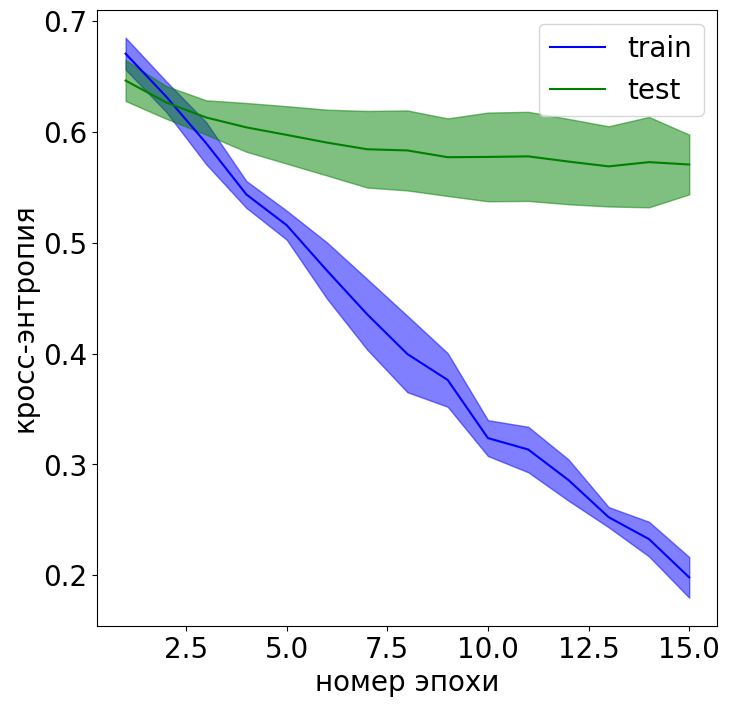

0.7619047619047619 0.8


In [108]:
plot_training_curves(train_losses_arrays, test_losses_arrays, T = 5, save = True)
print(best_f1_score, best_acc)
best_f1_scores.append(best_f1_score)
best_accs.append(best_acc)

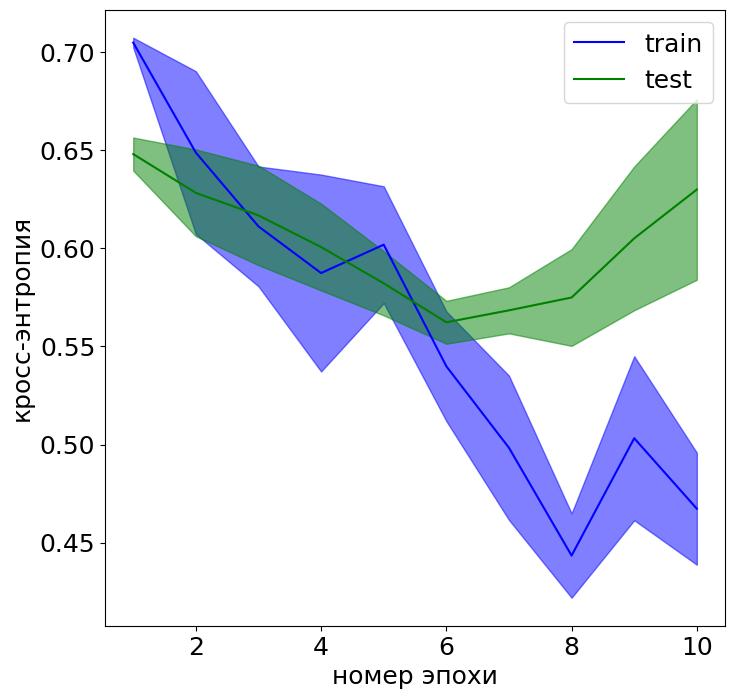

0.730423620025674 0.7666666666666667


In [66]:
plot_training_curves(train_losses_arrays, test_losses_arrays, T = 5, save = False)
print(best_f1_score, best_acc)
# best_f1_scores.append(best_f1_score)
# best_accs.append(best_acc)

In [18]:
best_f1_scores

NameError: name 'best_f1_scores' is not defined

In [109]:
best_f1_scores

[0.7619047619047619,
 0.7619047619047619,
 0.7,
 0.6590909090909092,
 0.7619047619047619]

In [110]:
best_accs

[0.8, 0.8, 0.7333333333333333, 0.7333333333333333, 0.8]

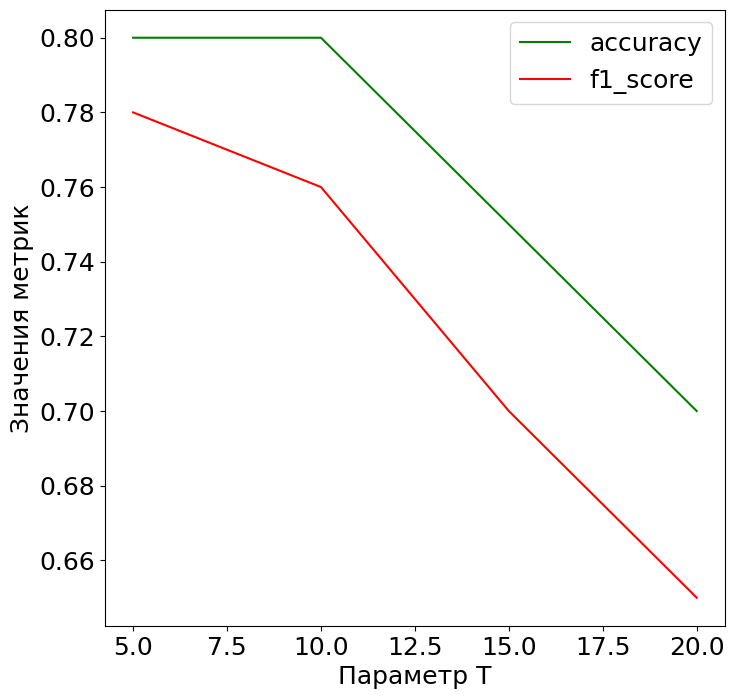

In [117]:
plt.figure(figsize = (8,8))

best_f1_scores = np.array([0.78, 0.76, 0.7, 0.65])
best_accs = np.array([0.8, 0.8, 0.75, 0.7])
T_array = np.array([5, 10, 15, 20])

plt.plot(T_array, best_accs, label = 'accuracy', color = 'g')
plt.plot(T_array, best_f1_scores, label = 'f1_score', color = 'r')

plt.xlabel('Параметр T')
plt.ylabel('Значения метрик')
plt.legend(loc = 'best')
plt.savefig('figures/final_res.png')
plt.show()